In [178]:
%matplotlib inline
from sklearn import neighbors
from nltk.stem.wordnet import WordNetLemmatizer
import string
from sklearn.metrics import accuracy_score
from sklearn import ensemble
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import pandas as pd
from sklearn import decomposition
import scipy
import sklearn
import spacy
from sklearn.model_selection import train_test_split
import re
import os
import gensim
from gensim.models import word2vec
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from nltk.corpus import gutenberg, stopwords
from collections import Counter

Our goal is to be able to confidently organize unlabeled news articles. This model will be inportant to help news orginizations with archives that are so volumous it would not be practical for employees to organize them by hand.

We are training our model with BBC news articles due to two factors. One, is that BBC is a highly respected news outlet with large amounts of content. And, two, this corpus comes with labels that can help us to analyze our unsupervised output as well as allow us to train a supervised model. Below you will find our order of operations and I will walk you through our procedures as they occur in the notebook.

## Order of operations

1. Import corpus of documents and document labels
- Tokenize all words, remove punctuation and convert words to their lemmas
- We will begin modelig by using two different methods of feature generation: TFIDF and CBOW word2vec
- We will test our clusters for density and well as cluster separation
- We will look at ground truth for the articles in each cluster to achieve two things
  - Utilizing the information to make an educated decision on which type of article that our         cluster is identifying 
  - Testing our certainty level by investigating how frequently our cluster selects the most         frequent ground truth label
- We will then perform supervised learning with KNN to see how well the unsupervised results compare
- We will display our findings by comparing the clusters with a scatterplot

 Here we are importing our documents and ground truth labels

In [148]:
df_tfidf_train = pd.DataFrame()
df_w2v_train = pd.DataFrame()
df_tfidf_test = pd.DataFrame()
df_w2v_test = pd.DataFrame()
article_list = []
ground_truth = []
categories = ['business', 'entertainment', 'politics', 'sport',  'tech']
for i, category in enumerate(categories):
    # is i coming first convention?
    for root, dirs, files in os.walk(os.path.join("./bbc_text",category)):
        # Are "root, dirs, files specifically related to os.walk or are they our names?
        # What is the ordering method for situations like this where we have 3 after the for
        # statement?
        for file in sorted(files):
            # Why did we sort the files?
            ground_truth.append(i)
            try:
                # I need a brief reminder about 'with' statement. Does it read as, "With 'do
                # something here' being 'f', then append 'f'
                with open(os.path.join(root,file),"r",encoding='utf-8') as f:
                    article_list.append(f.read())
            except:
                with open(os.path.join(root,file),"r",encoding='iso-8859-1') as f:
                    article_list.append(f.read())
print(article_list[0])
# When I tried to copy and paste yours it gave me this same empty list.              

Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL's underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sign up AOL

In [107]:
%ls bbc_text

README.TXT     entertainment/ sport/
business/      politics/      tech/


We are now converting the words to spacy tokens

In [ ]:
# Split here

In [108]:
nlp = spacy.load('en')
articles_tokenized = nlp.pipe(article_list)

We are eliminating grammar, stop words, and punctuation and are converting all words to their lemmas or root words. We are also creating a list of tokenized documents as well as sentenced. 

In [109]:
# Converting tokens to sentences and lemmas. Assuring punctuation is scrubbed
sentences = []
docs = [] # Docs for later use
for doc in articles_tokenized:
    docs.append(doc)
    for sentence in doc.sents:
        sentence = [
            token.lemma_
            for token in sentence
            if not token.is_stop
            and not token.is_punct
        ]
        sentences.append(sentence)


#print(sentences)
print('We have {} sentences'.format(len(sentences)))

We have 40606 sentences


In [110]:
X_train_sentences, X_test_sentences = train_test_split(sentences, test_size=0.25)

In [111]:
X_train_docs, X_test_docs, y_train_docs, y_test_docs = train_test_split(docs, ground_truth, test_size=0.25)

In [132]:
X_train_articles, X_test_articles, y_train_articles, y_test_articles = train_test_split(article_list, ground_truth, test_size=0.25)

In [112]:
# Make it so they are reusable
def generate_labels(df):
    predicted_clusters = {}
    for cluster_number in df.iloc[:, 0].unique():
        df_sub = df[df.iloc[:, 0] == cluster_number]
        counts = df_sub.groupby(df.columns[1]).count()
        #print(counts)
        predicted_label = counts.iloc[:, 0].argmax()
        predicted_clusters[cluster_number] = predicted_label
    return predicted_clusters

In [113]:
def generate_label_names(df):
    pred_label = df['predicted_label']
    labels = []
    for prediction in pred_label:
        if prediction == 0:
            labels.append('business')
        if prediction == 1:
            labels.append('entertainment')
        if prediction == 2:
            labels.append('politics')
        if prediction == 3:
            labels.append('sports')
        if prediction == 4:
            labels.append('tech')
    return labels

Here we are generating our features with CBOW word2vec. We determinded our window and the minimum count for words to be used in the feature set by trial and error

In [114]:
#--------Cbow---------
cbow_model = word2vec.Word2Vec(
    X_train_sentences,     
    min_count=5,   # Minimum word count threshold.
    window=5,      # Number of words around target word to consider.
    sg=0,          # CBOW
    sample=1e-3 ,  
    size=100,      # when referring to vector legnth is that dimensions?
    hs=1           
)

Here we are testing for similarity of words and looking deeper into the proximity of the vectors. Below we test whether the formula "man + woman - boy = ?" to see what it the model returns. In an ideal situation it would return "girl". 
We are also testing a variety of different words to determine which word is deemed most similar.
The results are displayed below the cell. We tested terms that would be similar to each other but would most likely fall into different clusters like "politician" and "musician".
We also tested how similar words are that should be identified as similar such as "study" and "research". Finally we tested whether the model would select the least similar word from a group of four. This test resulted in a subjectively accurate selection four of the five times. 

In [115]:
vocab = cbow_model.wv.vocab.keys()

print(cbow_model.wv.most_similar(positive=['woman', 'man'], negative=['boy']))
# Testing to see which words it will group with 'planet'
#print('Similarity to planet')
print('1:')
print(cbow_model.wv.most_similar('politician'))
print('2:')
print(cbow_model.wv.most_similar('scientist'))
print('3:')
print(cbow_model.wv.most_similar('artist'))
print('4:')
print(cbow_model.wv.most_similar('musician'))

# Testing for similarity 
#print('Cosine similatrity analysis:')
#print('study / research')
print('5:')
print(cbow_model.wv.similarity('study', 'research'))
#print('court / field')
print('6:')
print(cbow_model.wv.similarity('computer', 'tool'))
print('7:')
print(cbow_model.wv.similarity('musician', 'artist'))
print('8:')
print(cbow_model.wv.similarity('phone', 'device'))

# Testing to see if it will leave out the right word (looking for 'dinosaur')
#print('Which doesnt fit?')
#print('bat / bird / dinosaur / bee')
print(cbow_model.doesnt_match("man woman plane dog".split()))
print(cbow_model.doesnt_match("rock human computer dog".split()))
print(cbow_model.doesnt_match("rock human rocket dog".split()))
print(cbow_model.doesnt_match("car human rocket dog".split()))
print(cbow_model.doesnt_match("car human rocket boat".split()))

[('earn', 0.6616915464401245), ('m', 0.6484824419021606), ('holmes', 0.6196483969688416), ('medal', 0.5978129506111145), ('mcilroy', 0.5932034254074097), ('medallist', 0.5910307168960571), ('10,000', 0.5847156643867493), ('60', 0.5800455808639526), ('75', 0.5785653591156006), ('60,000', 0.5647566318511963)]
1:
[('lie', 0.8949429392814636), ('apologise', 0.8557747006416321), ('bnp', 0.8460294008255005), ('absolutely', 0.8419362902641296), ('direction', 0.8418500423431396), ('respect', 0.839292585849762), ('jewish', 0.8386468291282654), ('politic', 0.8308819532394409), ('exactly', 0.8291458487510681), ('activist', 0.8248475790023804)]
2:
[('honesty', 0.8734592795372009), ('brain', 0.8620617985725403), ('responsible', 0.8603904247283936), ('cultural', 0.8592484593391418), ('importance', 0.8585364818572998), ('teacher', 0.8574125170707703), ('undermine', 0.8532141447067261), ('teach', 0.8518876433372498), ('tolerance', 0.8516584634780884), ('integrity', 0.8509604930877686)]
3:
[('pop', 0.8

In this cell we are creating a vector list so that we can use the vectors as the input for our model. We are converting them into arrays so that they are able to be procesed by the model.

In [116]:
x = cbow_model.wv['human']
print(len(x))
vector_list_train = []
X_train_w2v = vector_list_train
for article in X_train_docs:
    article_vector = np.zeros_like(x)
    for word in article:
        word = word.lemma_ # is the _ after lemma to tell it a certin output style?
        if word in cbow_model.wv:
            vector = cbow_model.wv[word]
            article_vector += vector
    norm = normalize(article_vector.reshape(1, -1))
    norm = norm.flatten()
    vector_list_train.append(norm)
print(X_train_w2v[0])

100
[ 0.03851591  0.07492938  0.04791639  0.05267456  0.03142386 -0.12783895
  0.00104637 -0.10089663 -0.01104247  0.0196407   0.10359636 -0.13332523
  0.01991863 -0.09111465  0.06496456 -0.10703452  0.01811669  0.04640224
  0.01108371 -0.06760707 -0.07476064 -0.077577    0.02596164 -0.13347675
  0.0502339   0.0232606  -0.0493924  -0.04630836 -0.06456085 -0.07916149
 -0.23985623 -0.22352476 -0.13389349  0.24165669 -0.08565718  0.00255818
 -0.1148954   0.01619342 -0.20801011 -0.20096794  0.00214405  0.20658632
 -0.03139227  0.18321675 -0.06447958  0.02042579  0.10210613 -0.06596295
  0.09916607  0.04035118 -0.24027413 -0.04156716 -0.22050992  0.21331544
  0.07218624 -0.0214098  -0.03036044 -0.12828706 -0.18298478 -0.02268151
 -0.03234972  0.00528329  0.06532729 -0.0565336  -0.01685049 -0.04866337
  0.03330858  0.0040766  -0.06225149  0.06027443  0.04598761 -0.05698295
 -0.0935539   0.11088194 -0.02927193 -0.04782659  0.02540545 -0.05408333
 -0.08861472 -0.05003174  0.05035003  0.0244480

In [117]:
x = cbow_model.wv['human']
print(len(x))
vector_list_test = []
X_test_w2v = vector_list_test
for article in X_test_docs:
    article_vector = np.zeros_like(x)
    for word in article:
        word = word.lemma_ # is the _ after lemma to tell it a certin output style?
        if word in cbow_model.wv:
            vector = cbow_model.wv[word]
            article_vector += vector
    norm = normalize(article_vector.reshape(1, -1))
    norm = norm.flatten()
    vector_list_test.append(norm)
print(vector_list_test[0])

100
[  1.46327289e-02   8.31944719e-02   3.62546630e-02   1.40118208e-02
   3.08644529e-02  -1.79453492e-01   2.19580699e-02  -7.70079866e-02
  -1.58469509e-02   2.58317962e-02   3.71991470e-02  -1.50528178e-01
   2.00026203e-02  -6.40610307e-02   4.48656641e-02  -9.09617916e-02
  -1.52248787e-02   5.62275574e-03   3.03840585e-04  -3.00882179e-02
  -5.66722862e-02  -7.22127631e-02  -7.63966562e-03  -1.13178879e-01
   8.65078717e-02   1.95916016e-02  -6.88790306e-02  -4.27814294e-03
  -4.43548076e-02  -1.29655823e-01  -2.62948811e-01  -2.00814590e-01
  -6.70911670e-02   2.55853266e-01  -5.63735291e-02  -8.65652040e-03
  -6.55067116e-02  -4.51503601e-03  -1.86245114e-01  -2.18072817e-01
  -1.74079388e-02   1.42290354e-01  -5.22713084e-03   2.09086716e-01
  -7.62984678e-02   4.20922562e-02   8.34473595e-02  -4.82315570e-02
   1.11336835e-01   9.28358063e-02  -2.48477027e-01  -2.00720206e-02
  -2.12590456e-01   2.31381416e-01   9.95742753e-02  -3.96777391e-02
  -4.17933986e-02  -1.64458290

We are training our model and are testing which number of clusters is yeilds the most dense and separated clusters. We are also testing each model for accuracy by analyzing its performance next to the ground truth labels.

In [118]:
number_clusters = [2, 3, 5, 8, 10, 15, 20]
for num in number_clusters:
    model = KMeans(n_clusters=num).fit(X_train_w2v)
    prediction_w2v = model.predict(X_train_w2v)
    print(num)
    print('Silhouette Score')
    print(metrics.silhouette_score(X_train_w2v, prediction_w2v, metric='euclidean'))

2
Silhouette Score
0.254734
3
Silhouette Score
0.261436
5
Silhouette Score
0.321781
8
Silhouette Score
0.252272
10
Silhouette Score
0.232815
15
Silhouette Score
0.193699
20
Silhouette Score
0.183354


In [119]:
number_clusters = [2, 3, 5, 8, 10, 15, 20]
for num in number_clusters:
    model = KMeans(n_clusters=num).fit(X_train_w2v)
    prediction_w2v = model.predict(X_train_w2v)
    print(num)
    print('Calinski Harabaz Index')
    print(metrics.calinski_harabaz_score(X_train_w2v, prediction_w2v))

2
Calinski Harabaz Index
593.089554652
3
Calinski Harabaz Index
572.853649026
5
Calinski Harabaz Index
635.630603822
8
Calinski Harabaz Index
504.409481893
10
Calinski Harabaz Index
450.637046947
15
Calinski Harabaz Index
360.35448029
20
Calinski Harabaz Index
308.181411318


In [120]:
number_clusters = [2, 3, 5, 8, 10, 15, 20]
for num in number_clusters:
    model = KMeans(n_clusters=num).fit(X_train_w2v)
    prediction_w2v = model.predict(X_train_w2v)
    print(num)
    print('Opposite of the value of X on the K-means objective.')
    print(model.score(X_train_w2v))

2
Opposite of the value of X on the K-means objective.
-311.286368342
3
Opposite of the value of X on the K-means objective.
-250.044413974
5
Opposite of the value of X on the K-means objective.
-166.913259453
8
Opposite of the value of X on the K-means objective.
-135.00362893
10
Opposite of the value of X on the K-means objective.
-122.436098536
15
Opposite of the value of X on the K-means objective.
-104.595002971
20
Opposite of the value of X on the K-means objective.
-93.2445944782


In [121]:
number_clusters = [2, 3, 5, 8, 10, 15, 20]
for num in number_clusters:
    model_w2v = KMeans(n_clusters=num).fit(X_train_w2v)
    prediction_w2v = model_w2v.predict(X_train_w2v)
    print(num)
    print('Adjusted Rand Index')
    print(metrics.adjusted_rand_score(y_train_docs, prediction_w2v))

2
Adjusted Rand Index
0.323986644028
3
Adjusted Rand Index
0.477897126207
5
Adjusted Rand Index
0.811136215886
8
Adjusted Rand Index
0.612576924296
10
Adjusted Rand Index
0.550580591094
15
Adjusted Rand Index
0.386403240391
20
Adjusted Rand Index
0.330778236059


In [122]:
model_w2v = KMeans(n_clusters=5).fit(X_train_w2v)
prediction_w2v = model_w2v.predict(X_train_w2v)

In [123]:
prediction_w2v_test = model_w2v.predict(X_test_w2v)

In [124]:
df_w2v_train['pred'] = prediction_w2v
df_w2v_train['labels'] = y_train_docs

In [125]:
len(prediction_w2v_test)
#len(y_test_docs)

557

In [170]:
df_w2v_test['pred'] = prediction_w2v_test
df_w2v_test['labels'] = y_test_docs

We are now attempting semisupervised learning by finding which ground truth label our clusters most frequently predict and are assigning that ground truth label to the cluster. We are also investigating how often frequently the ground truth label is selected in each cluster. This will allow us to detremine how much confidence we can have in our clustering model and its selection.

In [84]:
label_map = generate_labels(df_w2v_train)
df_w2v_train['predicted_label'] = df_w2v_train.iloc[:, 0].map(lambda x: label_map[x])
df_w2v_train.head(50)

,pred,labels,predicted_label,label_names
0,3,4,4,tech
1,1,1,1,entertainment
2,3,4,4,tech
3,4,0,0,business
4,0,4,2,tech
5,0,2,2,politics
6,0,2,2,politics
7,4,0,0,business
8,0,2,2,business
9,4,0,0,business


In [87]:
label_names = generate_label_names(df_w2v_train)
df_w2v_train['label_names'] = label_names
df_w2v_train.head()

,pred,labels,predicted_label,label_names
0,3,4,4,tech
1,1,1,1,entertainment
2,3,4,4,tech
3,4,0,0,business
4,0,4,2,politics


In [171]:
print(df_w2v_test)

     pred  labels
0       1       0
1       0       2
2       1       0
3       4       3
4       1       0
5       4       3
6       1       0
7       4       1
8       4       3
9       2       1
10      4       3
11      3       4
12      4       4
13      4       3
14      3       4
15      0       2
16      3       4
17      0       2
18      0       2
19      0       2
20      3       4
21      0       2
22      1       0
23      2       1
24      1       0
25      2       1
26      0       2
27      1       0
28      4       3
29      0       0
..    ...     ...
527     0       1
528     3       4
529     2       1
530     2       1
531     4       3
532     4       3
533     4       3
534     2       1
535     1       0
536     2       1
537     0       2
538     3       4
539     0       0
540     2       1
541     3       4
542     2       1
543     3       4
544     2       1
545     1       1
546     1       0
547     4       1
548     1       0
549     0       2
550     3 

In [174]:
df_w2v_test['predicted_label'] = df_w2v_test.iloc[:, 0].map(lambda x: label_map[x])
df_w2v_test.head(50)

,pred,labels,predicted_label,label_names
0,1,0,1,business
1,0,2,2,politics
2,1,0,1,business
3,4,3,0,sports
4,1,0,1,business
5,4,3,0,sports
6,1,0,1,business
7,4,1,0,sports
8,4,3,0,sports
9,2,1,3,entertainment


In [182]:
label_names_test = generate_label_names(df_w2v_test)
df_w2v_test['label_names'] = label_names_test
df_w2v_test.head()

,pred,labels,predicted_label,label_names
0,1,0,1,entertainment
1,0,2,2,politics
2,1,0,1,entertainment
3,4,3,0,business
4,1,0,1,entertainment


In [180]:
df_w2v_test['predicted_label']
accuracy_score(df_w2v_test['labels'], df_w2v_test['predicted_label'])

0.34649910233393177

In [184]:
(df_w2v_test['labels'] == df_w2v_test['predicted_label']).mean()

0.34649910233393177

Here we we are training our supervised KNN model using a similar technique as the Kmeans. We are testing multiple counts of identifiers to see which gives us the most accurate results. We will be able to compare our unsupervised model's success to the success of the KNN model. 

In [88]:
num_neighbors = [2, 5, 10, 15, 20, 22, 25, 30, 40]
for neighbor in num_neighbors:
    knn_w2v = neighbors.KNeighborsClassifier(n_neighbors=neighbor)
    knn_w2v.fit(X_train_w2v, y_train_docs)
    # Convert test section to vectors here
    y_pred_knn_w2v = knn_w2v.predict(X_test_w2v)
    print(neighbor)
    print('Percentage accuracy')
    print(knn_w2v.score(X_test_w2v, y_test_docs))

2
Percentage accuracy
0.953321364452
5
Percentage accuracy
0.956912028725
10
Percentage accuracy
0.953321364452
15
Percentage accuracy
0.953321364452
20
Percentage accuracy
0.947935368043
22
Percentage accuracy
0.94973070018
25
Percentage accuracy
0.94434470377
30
Percentage accuracy
0.942549371634
40
Percentage accuracy
0.942549371634


In [90]:
num_estimators = [2, 5, 10, 15, 17, 18, 20, 40, 80, 100, 150, 200, 300]
for estimator in num_estimators:
    rfc_w2v = ensemble.RandomForestClassifier(n_estimators=estimator, max_depth=10)
    rfc_w2v.fit(X_train_w2v, y_train_docs)
    y_pred_rfc_w2v = rfc_w2v.predict(X_test_w2v)
    print(estimator)
    print('Percentage accuracy')
    print(rfc_w2v.score(X_test_w2v, y_test_docs)) 

2
Percentage accuracy
0.886894075404
5
Percentage accuracy
0.935368043088
10
Percentage accuracy
0.947935368043
15
Percentage accuracy
0.938958707361
17
Percentage accuracy
0.94973070018
18
Percentage accuracy
0.953321364452
20
Percentage accuracy
0.947935368043
40
Percentage accuracy
0.951526032316
80
Percentage accuracy
0.951526032316
100
Percentage accuracy
0.953321364452
150
Percentage accuracy
0.955116696589
200
Percentage accuracy
0.955116696589
300
Percentage accuracy
0.953321364452


Below is a visualization of the clusters we generated followed by a visualization of the ground truth article groups

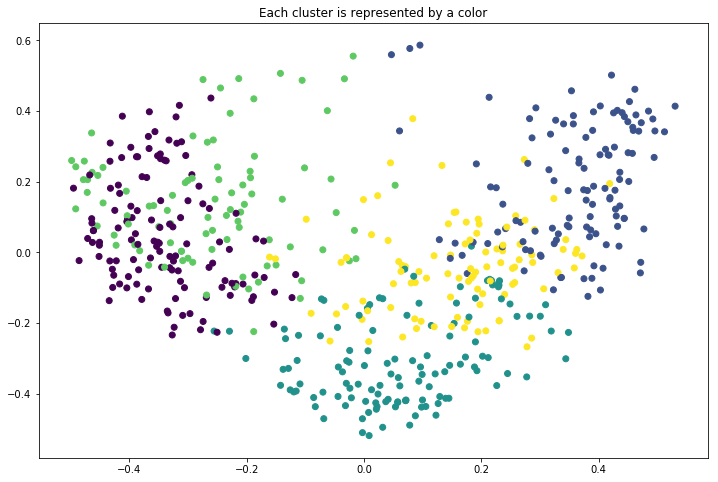

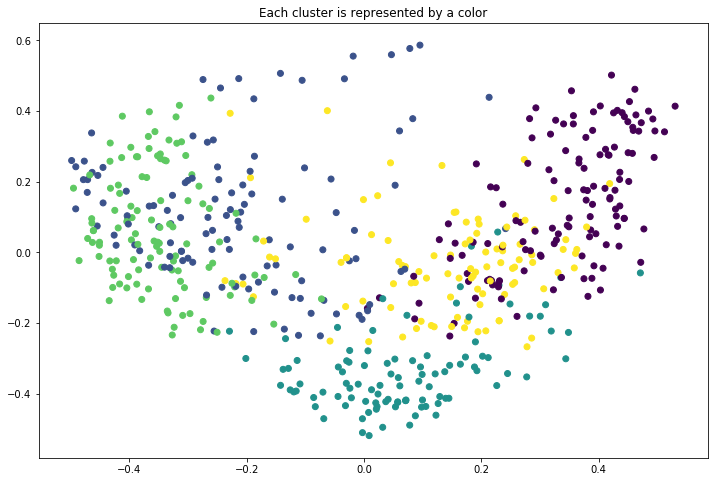

In [177]:
pca = decomposition.PCA(n_components=2)
pca.fit(np.array(X_test_w2v))
X_2 = pca.transform(X_test_w2v)

plt.figure(figsize=(12,8))
plt.scatter(X_2[:,0], X_2[:,1],c=df_w2v_test['predicted_label'])
plt.title('Each cluster is represented by a color')
plt.figure(figsize=(12,8))
plt.scatter(X_2[:,0], X_2[:,1],c=df_w2v_test['labels'])
plt.title('Each cluster is represented by a color')

We will now run the same procedures with tfidf to see if we can outperform the word2vec. All procedures are the same except for the tfidf feature generation. For our parameters we normalized the paragraphs so that longer paragraphs don't carry more weight then our shorter, we  set word frequency to 2 to assure that obscure terms don't skew the model, and we dropped words that occur in more then a quarter of the articles.

In [162]:
#-------------------------------------------tfidf-------------------------------------------------


vectorizer = TfidfVectorizer(max_df=0.25,          # drop words that occur in more than a quarter of the articles
                             min_df=2,             # only use words that appear at least twice
                             stop_words='english', # picking list of stop words
                             lowercase=True,       # convert everything to lower case 
                             use_idf=True,         # use inverse document frequencies in our weighting
                             norm=u'l2',           # Treat longer and shorter paragraphs equally
                             smooth_idf=True       # Prevent divide-by-zero errors
                            )


# Applying the vectorizer
article_list_tfidf_train = vectorizer.fit_transform(X_train_articles)
article_list_tfidf_test = vectorizer.fit_transform(X_test_articles)
print("Number of features: %d" % article_list_tfidf_train.get_shape()[1])

#X_train_tfidf, X_test_tfidf= train_test_split(article_list_tfidf, test_size=0.4, random_state=0)


# Reshape the vectorizer output to be legible 
article_list_tfidf_csr = article_list_tfidf_train.tocsr()

# number of articles
n = article_list_tfidf_csr.shape[0]

# Making a list of dictionaries, one per article
tfidf_bypara = [{} for _ in range(0,n)]

# List of features
terms = vectorizer.get_feature_names()




print('Original article:', article_list[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 15135
Original article: Japan narrowly escapes recession

Japan's economy teetered on the brink of a technical recession in the three months to September, figures show.

Revised figures indicated growth of just 0.1% - and a similar-sized contraction in the previous quarter. On an annual basis, the data suggests annual growth of just 0.2%, suggesting a much more hesitant recovery than had previously been thought. A common technical definition of a recession is two successive quarters of negative growth.

The government was keen to play down the worrying implications of the data. "I maintain the view that Japan's economy remains in a minor adjustment phase in an upward climb, and we will monitor developments carefully," said economy minister Heizo Takenaka. But in the face of the strengthening yen making exports less competitive and indications of weakening economic conditions ahead, observers were less sanguine. "It's painting a picture of a recovery... much patchier

In [163]:
number_clusters = [2, 3, 5, 8, 10, 15, 20]
X_train_tfidf = article_list_tfidf_train
X_test_tfidf = article_list_tfidf_test
for num in number_clusters:
    model_tfidf = KMeans(n_clusters=num).fit(X_train_tfidf)
    prediction_tfidf = model_tfidf.predict(X_train_tfidf)
    print(num)
    print('Silhouette Score')
    print(metrics.silhouette_score(X_train_tfidf, prediction_tfidf, metric='euclidean'))

2
Silhouette Score
0.00541571533533
3
Silhouette Score
0.00829139645315
5
Silhouette Score
0.0121676919136
8
Silhouette Score
0.0131167108508
10
Silhouette Score
0.0143455380668
15
Silhouette Score
0.0178593387607
20
Silhouette Score
0.0196333436911


In [188]:
number_clusters = [2, 3, 5, 8, 10, 15, 20]
X_train_tfidf_dense = X_train_tfidf.toarray()
for num in number_clusters:
    model_tfidf = KMeans(n_clusters=num).fit(X_train_tfidf_dense)
    prediction_tfidf = model_tfidf.predict(X_train_tfidf_dense)
    print(num)
    print('Calinski Harabaz Index')
    print(metrics.calinski_harabaz_score(X_train_tfidf_dense, prediction_tfidf))

2
Calinski Harabaz Index
12.7045924481
3
Calinski Harabaz Index
13.0886972209
5
Calinski Harabaz Index
11.2748462636
8
Calinski Harabaz Index
9.45687620952
10
Calinski Harabaz Index
8.58157862758
15
Calinski Harabaz Index
7.31668226231
20
Calinski Harabaz Index
6.48526298262


In [185]:
number_clusters = [2, 3, 5, 8, 10, 15, 20]
for num in number_clusters:
    model_tfidf = KMeans(n_clusters=num).fit(X_train_tfidf)
    prediction_tfidf = model_tfidf.predict(X_train_tfidf)
    print(num)
    print('Opposite of the value of X on the K-means objective.')
    print(model.score(X_train_tfidf))

2
Opposite of the value of X on the K-means objective.


ValueError: Incorrect number of features. Got 15135 features, expected 100

In [ ]:
number_clusters = [2, 3, 5, 8, 10, 15, 20]
for num in number_clusters:
    X_train_tfidf = article_list_tfidf_train
    model_tfidf = KMeans(n_clusters=num).fit(X_train_tfidf)
    prediction_tfidf = model_tfidf.predict(X_train_tfidf)
    print(num)
    print('Adjusted Rand Index')
    print(metrics.adjusted_rand_score(y_train_docs, prediction_tfidf))

In [165]:
model_tfidf = KMeans(n_clusters=5).fit(X_train_tfidf)
prediction_tfidf = model_tfidf.predict(X_train_tfidf)

In [166]:
prediction_tfisf_test = model_tfidf.predict(X_test_tfidf)

ValueError: Incorrect number of features. Got 7948 features, expected 15135

In [151]:
df_tfidf_train['pred'] = prediction_tfidf
df_tfidf_train['labels'] = y_train_docs

In [157]:
df_tfidf_test['pred'] = prediction_tfidf_test
df_tfidf_test['labels'] = y_test_docs

NameError: name 'prediction_tfidf_test' is not defined

In [146]:
label_map = generate_labels(df_tfidf_train)
df_tfidf_train['predicted_label'] = df_tfidf_train.iloc[:, 0].map(lambda x: label_map[x])
df_tfidf_train.head(50)

IndexError: single positional indexer is out-of-bounds

In [ ]:
label_map = generate_labels(df_tfidf)
df_tfidf['predicted_label'] = df_tfidf.iloc[:, 0].map(lambda x: label_map[x])
df_tfidf.head(50)

In [79]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, ground_truth , test_size=0.25)

In [87]:
num_neighbors = [2, 5, 10, 15, 20, 40, 43, 50, 60]
for neighbor in num_neighbors:
    knn_tfidf = neighbors.KNeighborsClassifier(n_neighbors=neighbor)
    knn_tfidf.fit(X_train_tfidf, y_train_tfidf)
    y_pred_knn_tfidf = knn_tfidf.predict(X_test_tfidf)
    print('Percentage accuracy')
    print(neighbor)
    print(knn_tfidf.score(X_test_tfidf, y_test_tfidf))

Percentage accuracy
2
0.928186714542
Percentage accuracy
5
0.951526032316
Percentage accuracy
10
0.964093357271
Percentage accuracy
15
0.956912028725
Percentage accuracy
20
0.96947935368
Percentage accuracy
40
0.980251346499
Percentage accuracy
43
0.980251346499
Percentage accuracy
50
0.978456014363
Percentage accuracy
60
0.976660682226


In [91]:
num_estimators = [2, 5, 10, 15, 17, 18, 20, 40, 80, 90, 100, 110, 120, 130, 140, 150, 200, 300]
for estimator in num_estimators:
    rfc_tfidf = ensemble.RandomForestClassifier(n_estimators=estimator, max_depth=10)
    rfc_tfidf.fit(X_train_tfidf, y_train_tfidf)
    y_pred_rfc_tfidf = rfc_tfidf.predict(X_test_tfidf)
    print('Percentage accuracy')
    print(estimator)
    print(rfc_tfidf.score(X_test_tfidf, y_test_tfidf)) 

Percentage accuracy
2
0.579892280072
Percentage accuracy
5
0.737881508079
Percentage accuracy
10
0.861759425494
Percentage accuracy
15
0.881508078995
Percentage accuracy
17
0.861759425494
Percentage accuracy
18
0.881508078995
Percentage accuracy
20
0.908438061041
Percentage accuracy
40
0.921005385996
Percentage accuracy
80
0.922800718133
Percentage accuracy
90
0.933572710952
Percentage accuracy
100
0.91921005386
Percentage accuracy
110
0.91921005386
Percentage accuracy
120
0.924596050269
Percentage accuracy
130
0.929982046679
Percentage accuracy
140
0.933572710952
Percentage accuracy
150
0.929982046679
Percentage accuracy
200
0.929982046679
Percentage accuracy
300
0.933572710952


In [47]:
# Should I use a similar loop as we did before to convert this into a list of arrays?
pca = decomposition.PCA(n_components=2)
pca.fit(np.array(X_tfidf))
X_2 = pca.transform(X_tfidf)

plt.figure(figsize=(12,8))
plt.scatter(X_2[:,0], X_2[:,1],c=df_tfidf['predicted_label'])
plt.title('Each cluster is represented by a color')
plt.figure(figsize=(12,8))
plt.scatter(X_2[:,0], X_2[:,1],c=df_tfidf['labels'])
plt.title('Each cluster is represented by a color')

ValueError: setting an array element with a sequence.

## Conclusion: